<a href="https://colab.research.google.com/github/Anugrg/Fall-Detection/blob/master/playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FOR COMET WEB APP INTIALISATION:

In [ ]:
pip install comet_ml --upgrade 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from comet_ml import Experiment

# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="SsJ5fAlLtYLpIweSJJuDa7992",
                        project_name="general", workspace="anugrg")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/anugrg/general/66eeed7343c34eef8179d4fb91f37a05



# SET A FIXED RANDOM SEED VALUE FOR REPRODUCIBILITY

In [ ]:
# Set a seed value
seed_value= 1238 # 1. Set `PYTHONHASHSEED` environment variable at a fixed value before:1232,1235
import os
os.environ['PYTHONHASHSEED']=str(seed_value)# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras


print(pd.__version__)
print(tf.__version__)
print(np.__version__)
print(keras.__version__)
!nvcc --version

1.1.5
2.4.1
1.19.5
2.4.0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


# BELOW IS THE START OF THE LSTM CODE

In [ ]:
import pandas as pd
import argparse
import os
import os.path
import numpy as np
import re
import tensorflow as tf
from sklearn.utils import class_weight

""" This program assumes that the csv files have 
been divided according to the camera channels or angles and the action
classes 
"""

def process_csv(csv, label):
    temp = csv.values
    data = temp.astype(float)
    x = []
    y = []
    if len(data) < 40:
        print("less than 40 frames")
        pad = create_pad()
        # print("pad",pad)
        data = pad_sequence(data, pad)
        # print("data",data)
        x.append(data)
        # print(np.array(x).shape)
    elif len(data) >= 40:
        # print("greater than 40 frames")
        for i in range(40, len(data)):
            x.append(data[i - 40:i])
    print(np.array(x).shape)
    n = len(x) # length will be 1 for shorter frames as only 1 sequence of 40 can be made after padding
    print("n",n)
    y = create_labels(n, label)
    return x, y


def create_labels(n, lab):
    Y = []
    if lab == 0:
        for j in range(n):
            Y.append([0])
    elif lab == 1:
        for j in range(n):
            Y.append([1])
    elif lab == 2:
        for j in range(n):
            Y.append([2])
    elif lab == 3:
        for j in range(n):
            Y.append([3])
    elif lab == 4:
        for j in range(n):
            Y.append([4])
    return Y


def pad_sequence(data, pad):
    print("inside pad sequence")
    # print(data)
    # print("pad",pad)
    if len(data) < 40:
        gap = 40 - len(data)
        # print("spread: ",gap)
        for i in range(gap):
            data = np.vstack((data, pad))
    return data


def create_pad():
    pad = []
    for i in range(0, 36):#24
        pad.append(0.0)
    return pad


def one_hot_encoder(data):
    one_hot_y = tf.one_hot(data.astype(np.int32), depth=5, axis=1, dtype=tf.int32)
    return one_hot_y

def load_data(directory): 
  X = []
  Y = []
  for dir_path, dir_names, files in os.walk(directory):
    for file in files:
      if re.search("sit", file): #time #sit
        label = 0
      elif re.search("stand", file): #clap #stand
        label = 1
      elif re.search("walk", file): #call  #walk
        label = 2
      elif re.search("bend", file): #point #bend
        label = 3
        print("yes")
      elif re.search("fall", file): #wave #fall
        label = 4
   
      path = dir_path + "/" + file
      print(path)
      print("label",label)
      csv = pd.read_csv(path, header=None, encoding='utf-7')
      csv.drop(csv.index[0], inplace=True)
      if csv.empty:
        print("empty: "+ path)    
        break
      if len(csv.columns) > 36: #24
        for i in range(36,len(csv.columns)): #24
          csv.drop([i], axis=1, inplace=True)
      is_NaN = csv.isnull()
      if any(is_NaN.any(axis=1)) == True:
        print(path)
      csv.fillna(0.0,inplace=True)  
      temp_x, temp_y = process_csv(csv, label)
      X.extend(temp_x)
      Y.extend(temp_y)
  return X,Y

# ch1, ch2, ch3, ch4
# fall, sit, walk, bend, stand

file_names = ["Train/" ,"Test/"] #, "validation/"] 
directory = ["/content/drive/My Drive/lstm models/" + i for i in file_names] 
#directory = ["/content/drive/My Drive/lstm models/csv-lstm/train/"]
label = 0
X_train, Y_train = load_data(directory[0])
X_test, Y_test = load_data(directory[1])
#X_val, Y_val = load_data(directory[2])

# convert into numpy arrays from list 
X_train = np.array(X_train)
X_test = np.array(X_test)
#X_val = np.array(X_val)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
#Y_val = np.array(Y_val)
Y_train_1 = Y_train 
Y_test_1 = Y_test
#Y_val_1 = Y_val

print(Y_train[0])
print( np.unique(Y_train))
# for imbalanced class otherwise comment out
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train.reshape(-1))
class_weight = {0: class_weight[0], 1: class_weight[1], 2: class_weight[2], 3: class_weight[3], 4: class_weight[4]    }

# To get vector like [0 0 0 1 0] results in Y
Y_train = np.array(one_hot_encoder(Y_train)).reshape(-1, 5).astype(np.int32)
Y_test = np.array(one_hot_encoder(Y_test)).reshape(-1, 5).astype(np.int32)
#Y_val = np.array(one_hot_encoder(Y_val)).reshape(-1, 5).astype(np.int32)





yes
/content/drive/My Drive/lstm models/Train/subject_fall/fast_walk/ch1/bend/bend1.csv
label 3
less than 40 frames
inside pad sequence
(1, 40, 36)
n 1
yes
/content/drive/My Drive/lstm models/Train/subject_fall/fast_walk/ch1/bend/bend2.csv
label 3
less than 40 frames
inside pad sequence
(1, 40, 36)
n 1
yes
/content/drive/My Drive/lstm models/Train/subject_fall/fast_walk/ch1/bend/bend3.csv
label 3
less than 40 frames
inside pad sequence
(1, 40, 36)
n 1
yes
/content/drive/My Drive/lstm models/Train/subject_fall/fast_walk/ch1/bend/bend4.csv
label 3
less than 40 frames
inside pad sequence
(1, 40, 36)
n 1
yes
/content/drive/My Drive/lstm models/Train/subject_fall/fast_walk/ch1/bend/bend5.csv
label 3
less than 40 frames
inside pad sequence
(1, 40, 36)
n 1
yes
/content/drive/My Drive/lstm models/Train/subject_fall/fast_walk/ch1/bend/bend6.csv
label 3
less than 40 frames
inside pad sequence
(1, 40, 36)
n 1
yes
/content/drive/My Drive/lstm models/Train/subject_fall/fast_walk/ch1/bend/bend7.csv


In [ ]:
print(X_train.shape)
print(Y_train.shape)
#print(X_test.shape)
#print(Y_test.shape)
#print(X_val.shape)
#print(Y_val.shape)
print(X_train[0].shape)

(8136, 40, 36)
(8136, 5)
(40, 36)


In [ ]:
print(class_weight)

{0: 2.08348271446863, 1: 1.615888778550149, 2: 0.3445997458703939, 3: 2.511111111111111, 4: 1.663803680981595}


# CHECK IF NULL VALUES:

In [ ]:
check = [X_train,X_test]

for i in range(len(check)):
  print(np.isnan(check[i]).any())
  where_are_NaNs = np.isnan(check[i]).any()
  print(where_are_NaNs)

False
False
False
False


CHECK SHAPE OF TRAIN AND TEST:

In [ ]:
print(X_train[100:])
print(Y_train[10:])

In [ ]:
# check file shape and print some values
print(X_train.shape)
print(X_train[22].shape)
print(Y_train.shape)
print(Y_train[22][1])
print(type(Y_train[22][1]))
print(class_weight)
print(X_test.shape)
print(Y_test.shape)
print(Y_train[0:5])
print(X_train[1000])
print(Y_train[1000])
print(Y_test[100])
print(X_val[50:])
print(Y_val[50])







# !(IGNORE)! UNLESS CASE OF CLASSIFIER EXPERIMENT WITH SOME CLASSES



In [ ]:
def extract_sit_stand(Y, track):
  new_y = []
  for i in range(len(Y)):
    if (Y[i,0] == 0 or Y[i,0] == 1):
      track.append(i)
      new_y.append(Y[i,0]) 
  return track, new_y 

def display(Y,track):
  for i in range(len(track)):
    print(Y[track[i], 0])

def assign(X,X_main, track):
  print(len(track))
  for i in range(len(track)):
    X[i ,:,: ] = X_main[track[i]] 

Y_sit_stand_train = []
Y_sit_stand_test = []
X_sit_stand_train = np.random.random([959, 40, 36]).astype(np.float32)
X_sit_stand_test = np.random.random([ 120, 40 , 36]).astype(np.float32)

track_train, Y_sit_stand_train = extract_sit_stand(Y_train_1, track = []) 
track_test, Y_sit_stand_test = extract_sit_stand(Y_test_1, track = [])
print(len(track_train))
print(len(track_test))
# print("y train values:")
# display(Y_train_1,track_train)
# print("y test values:")
# display(Y_test_1, track_test)

assign(X_sit_stand_train,X_train, track_train)
assign(X_sit_stand_test,X_test, track_test) 

class_weight = class_weight.compute_class_weight('balanced', np.unique(np.array(Y_sit_stand_train)), np.array(Y_sit_stand_train).reshape(-1))
class_weight = {0: class_weight[0], 1: class_weight[1]}

print(len(X_sit_stand_train))  
print(len(X_sit_stand_test))

print(len(Y_sit_stand_train))
print(len(Y_sit_stand_tecPanelst))

In [ ]:
Y_train = np.array(one_hot_encoder(np.array(Y_sit_stand_train))).reshape(-1, 5).astype(np.int32)
Y_test = np.array(one_hot_encoder(np.array(Y_sit_stand_test))).reshape(-1, 5).astype(np.int32)

X_train = np.array(X_sit_stand_train)
X_test = np.array(X_sit_stand_test)

print(Y_train)
print(Y_test)
print(X_train.shape)
print(X_test.shape)
print(class_weight)

# SPLIT DATASET INTO TRAIN AND VALIDATION

In [ ]:
from sklearn.model_selection import train_test_split


X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.1, stratify = Y_test, shuffle=True)

# CHECK THE SHAPE OF DATA AFTER SPLIT:

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(Y_val[50])
print(X_test.shape)

(8136, 40, 36)
(8136, 5)
(208, 40, 36)
(208, 5)
[0 0 1 0 0]
(1867, 40, 36)


#IN CASE OF LOADING TENSORBOARD FOR VISUALIZATION:

In [ ]:
%reload_ext tensorboard

# Random removal of samples


In [ ]:
from random import randint

n = 0
to_remove = []
for i in range(len(Y_train)):
  pos = randint(0,6000)
  if Y_train.argmax(1)[pos] == 2: 
     to_remove.append(pos)
     n = n + 1
     if n >= 3000:
       break

print(to_remove)   


[4032, 1737, 2893, 2928, 5048, 2846, 2476, 5087, 1855, 3712, 1848, 1908, 5309, 1996, 2659, 3686, 3237, 5611, 3336, 5509, 2474, 3908, 1598, 5056, 2773, 2032, 3114, 3922, 1796, 2029, 5970, 4497, 4673, 3069, 4170, 2458, 5519, 4698, 2065, 2595, 3289, 4519, 2050, 1660, 3257, 2476, 2713, 5211, 1976, 1755, 4644, 5221, 2945, 3266, 3993, 4534, 3815, 4186, 4543, 5259, 1254, 5607, 3273, 5161, 2449, 1772, 2249, 5060, 5168, 4463, 3656, 1725, 3296, 2614, 1655, 3326, 1263, 1683, 4453, 1894, 3475, 4309, 3436, 3777, 2904, 3911, 2472, 2791, 2570, 4214, 1819, 1722, 5216, 4402, 2076, 4140, 1407, 1363, 4443, 3237, 3161, 3393, 5582, 3158, 1949, 3326, 5316, 2574, 4023, 3327, 1347, 5390, 2523, 5111, 1889, 2654, 3063, 3915, 2574, 1468, 5989, 1662, 3822, 4624, 3200, 2027, 1711, 2082, 4593, 3021, 5464, 3426, 1299, 1489, 1612, 2657, 3649, 2873, 3793, 2489, 4253, 1936, 2515, 3649, 5626, 2903, 4589, 4000, 4290, 3738, 4365, 3161, 3738, 2973, 3519, 4112, 1372, 3049, 5346, 3524, 2597, 1804, 2333, 1510, 3500, 1313, 344

In [ ]:
X_train = np.delete(X_train,to_remove,0)
Y_train = np.delete(Y_train,to_remove,0)
print(len(X_train))
print(len(Y_train))


6016
6016


**CLASS WEIGHT AFTER REMOVAL OF SOME SAMPLES**

In [ ]:
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_train.argmax(1)), Y_train.argmax(1))
class_weight = {0: class_weight[0], 1: class_weight[1], 2: class_weight[2], 3: class_weight[3], 4: class_weight[4]    }
print(class_weight)

{0: 1.5405889884763124, 1: 1.1948361469712017, 2: 0.462413528055342, 3: 1.85679012345679, 4: 1.2302658486707567}


In [ ]:
np.unique(Y_train.argmax(1))

print(Y_train.argmax(1)[1000])

for i in range(len(Y_train)):
  if Y_train.argmax(1)[i] == 2:
    print("walk")


# CHECK THE NUMBER OF SAMPLES IN EACH CLASS:

In [ ]:


sit = 0
stand = 0
walk = 0
bend = 0
fall = 0
"""
time = 0
clap =0 
call = 0
point = 0
wave = 0
"""
y = Y_val
for i in range(len(y)):
  if y.argmax(1)[i] == 0:
    sit+=1
  elif y.argmax(1)[i] == 1:
    stand+=1 
  elif y.argmax(1)[i] == 2:
    walk+=1
  elif y.argmax(1)[i] == 3:
    bend+=1
  elif y.argmax(1)[i] == 4:
    fall+=1


print("sit: ",sit)
print("stand: ",stand)
print("walk: ",walk)
print("bend: ",bend)
print("fall: ",fall)

"""
print("time: ",time)
print("clap: ",clap)
print("call: ",call)
print("point: ",point)
print("wave: ",wave)
"""

sit:  11
stand:  11
walk:  138
bend:  18
fall:  30


'\nprint("time: ",time)\nprint("clap: ",clap)\nprint("call: ",call)\nprint("point: ",point)\nprint("wave: ",wave)\n'

# SETTING VALUES FOR MODEL

In [ ]:
# set the values of parameters 
epochs = 60
batch_size = 64
time_steps = 40 # a.k.a, length of sequence 
num_features = 36
num_output = 5 # output size depends on number of classes
hidden_units = 1 # output dimensionality of each LSTM layer



# BUILDING MODEL:

In [ ]:
from tensorflow import keras
from keras import layers
import datetime, os

def build_model(time_steps, n_features, units):
    model = tf.keras.models.Sequential(
        [
            #tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(time_steps,n_features)),
            #tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'), 
            #tf.keras.layers.Dropout(0.8),
            #tf.keras.layers.MaxPooling1D(pool_size=3),
	          #tf.keras.layers.Flatten(),
            tf.keras.layers.Masking(mask_value=0.,input_shape=(time_steps,n_features)),
            #tf.keras.layers.LSTM(5, return_sequences=True,input_shape=(time_steps, n_features)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units,return_sequences=True,input_shape=(time_steps, n_features))),
            # tf.keras.layers.RNN(tf.keras.layers.LSTMCell(1,dropout=0.2),return_sequences=True),
            #tf.keras.layers.LSTM(5, dropout=0.8, return_sequences=True),
            #tf.keras.layers.RNN(tf.keras.experimental.PeepholeLSTMCell(5, recurrent_dropout=0.4), return_sequences=True),
            #tf.keras.layers.RNN(tf.keras.experimental.PeepholeLSTMCell(num_output, activation='softmax'))
            #tf.keras.layers.Dense(units, activation='relu'),
            #tf.keras.layers.Dropout(0.5),
            #tf.keras.layers.Dense(5, activation='softmax')
            tf.keras.layers.LSTM(num_output,recurrent_dropout=0.0,activation='softmax')
        ])

    return model

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                              patience=20, min_lr=0.001,verbose=1)

LSTM_model = build_model(time_steps, num_features, hidden_units)
LSTM_model.summary()

LSTM_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001),
                   loss='categorical_crossentropy', 
                   metrics=['categorical_crossentropy',
                     'accuracy'])


history = LSTM_model.fit(X_train, Y_train, batch_size= batch_size, class_weight=class_weight,
                         validation_data = (X_val,Y_val),validation_freq =1, 
                         validation_batch_size= 16 ,epochs= epochs,shuffle= True) 



# callbacks=[callback],
# , class_weight=class_weight


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 40, 36)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 2)             304       
_________________________________________________________________
lstm_3 (LSTM)                (None, 5)                 160       
Total params: 464
Trainable params: 464
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
128/128 [==============================] - 16s 60ms/step - loss: 1.5813 - categorical_crossentropy: 1.5974 - accuracy: 0.1809 - val_loss: 1.6015 - val_categorical_crossentropy: 1.6015 - val_accuracy: 0.2260
Epoch 2/60
128/128 [==============================] - 6s 44ms/step - loss: 1.4642 - categorical_crossentropy: 1.4651 - accuracy: 0.6146 - val_loss: 1.5818 - val_categor

# KERAS FUNCTIONAL API IMPLEMENTATION ALTERNATIVE TO ABOVE MODEL BUILDING: (STATUS INCOMPLETE)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


inputs = keras.Input(shape=(40,36))
x = layers.Masking(mask_value=0., input_shape=(40, 36))(inputs)
lstm = layers.LSTM(1, return_sequences=True, input_shape=(40,36))
h = lstm(x)
print(h)
outputs = layers.LSTM(5, activation='softmax')(h)

model = keras.Model(inputs=inputs, outputs=outputs, name="lstm_model")
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001),
                   loss='categorical_crossentropy', 
                   metrics=['categorical_crossentropy',
                     'accuracy'])

history = model.fit(X_train, y_train, batch_size= batch_size,
                         validation_data = (X_val,y_val),validation_freq =1,
                         validation_batch_size= 16 ,epochs= epochs, 
                         shuffle= True) 



#IF IN CASE FOR VISUALIZING TRAINING IN TENSORBOARD

In [ ]:
%tensorboard --logdir logs

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# PLOT ACCURACY AND LOSS

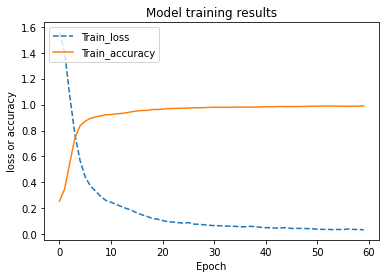

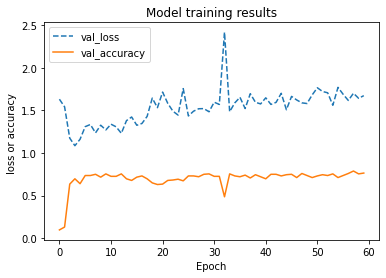

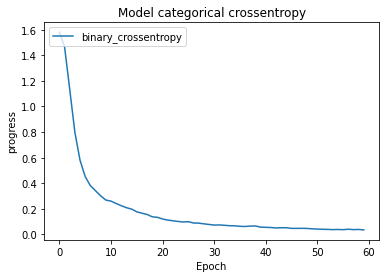

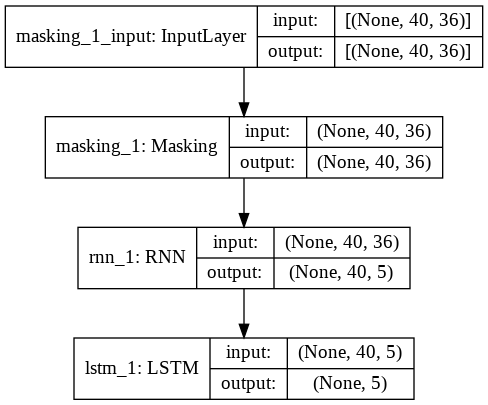

In [ ]:
# plot the accuracy and loss of the model across epochs
import matplotlib.pyplot as plt

plt.plot(history.epoch, history.history['loss'], linestyle="--")
plt.plot(history.epoch, history.history['accuracy'] )

plt.title('Model training results')
plt.ylabel('loss or accuracy')
plt.xlabel('Epoch')
plt.legend(['Train_loss', 'Train_accuracy'], loc='upper left')
plt.show()

plt.plot(history.epoch, LSTM_model.history.history['val_loss'], linestyle="--")
plt.plot(history.epoch, LSTM_model.history.history['val_accuracy'] )

plt.title('Model training results')
plt.ylabel('loss or accuracy ')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'val_accuracy'], loc='upper left')
plt.show()

plt.plot(history.epoch, history.history['categorical_crossentropy'])
plt.title('Model categorical crossentropy')
plt.ylabel('progress')
plt.xlabel('Epoch')
plt.legend(['binary_crossentropy'],loc = 'upper left')
plt.show()

keras.utils.plot_model(LSTM_model, 'multi_input_and_output_model.png', show_shapes=True)



# CONFUSION MATRIX FOR VALIDATION SET RESULTS:

precision 71.45833333333333
recall 74.51923076923077
f_score 72.40289770553893
number of occurrences of each class in test data None
confusion matrix
[[  0   0   2   9   0]
 [  0   0   4   7   0]
 [  0   0 130   8   0]
 [  0   0   1   9   8]
 [  0   0   7   7  16]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, -3.0, 'Predicted label')

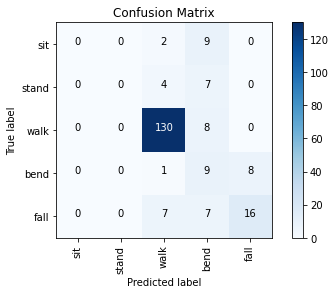

In [ ]:

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools


pred = LSTM_model.predict(X_val)
n_classes = 5
"""
LABELS = [ 
    "time",
    "clap",
    "call",
    "point",
    "wave"
    ] 
"""
LABELS = [ 
    "sit",
    "stand",
    "walk",
    "bend",
    "fall"
    ]     

# LABELS = [ "Normal","FALL"]
precision, recall, f_score, support = metrics.precision_recall_fscore_support(Y_val.argmax(1), pred.argmax(1),average="weighted")

print("precision",100 * precision)
print("recall", 100 * recall)
print("f_score",100 * f_score)

print("number of occurrences of each class in test data", support)
print("confusion matrix")
confusion_matrix_basic = metrics.confusion_matrix(Y_val.argmax(1), pred.argmax(1))
print(confusion_matrix_basic)

cm = confusion_matrix(  Y_val.argmax(1), pred.argmax(1) ) 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j], fmt),
  horizontalalignment="center", 
  color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
X_test = []
x = []
Y = []
def one_hot_encoder(data):
    one_hot_y = tf.one_hot(data.astype(np.int32), depth=5, axis=1, dtype=tf.int32)
    return one_hot_y  

csv = pd.read_csv("/content/walk1.csv", header=None, encoding='utf-7')

if len(csv.columns) > 36:
        for i in range(36,len(csv.columns)):
          csv.drop([i], axis=1, inplace=True)

test = csv.values
data = test.astype(float)
pad = []
#for i in range(0, 36):
#        pad.append(0.0)

for i in range(40, len(data)):
            x.append(data[i - 40:i])
"""
if len(data) < 40:
  gap = 40 - len(data)
  for i in range(gap):
    data = np.vstack((data, pad))
"""
n = len(x)
# x.append(data)
for i in range(n):
  Y.append([2])
# Y = [2]
X_test.extend(x)
Y_test = np.array(Y)
X_test = np.array(X_test)
Y_test = np.array(one_hot_encoder(Y_test)).reshape(-1, 5).astype(np.int32)
print(Y_test.shape)
print(X_test.shape)
print(X_test)
print(Y_test.argmax(1))

# IN CASE OF LOADING MODEL AND THEN EVALUATE:

In [ ]:
LSTM_model = tf.keras.models.load_model("/content/drive/My Drive/newlstmsample/C/LSTM_new_5_class_3.h5"  )

# MODEL EVALUATION:

In [ ]:
X_test, Y_test = load_data("/content/drive/My Drive/lstm models/csv-lstm/extract/clean/")
X_test = np.array(X_test)
Y_test = np.array(Y_test)
Y_test = np.array(one_hot_encoder(Y_test)).reshape(-1, 5).astype(np.int32)
print(Y_test.shape)


# TEST MODEL

In [ ]:

results = LSTM_model.evaluate(X_test, Y_test,batch_size=1)



1867/1867 [==============================] - 14s 7ms/step - loss: 1.7240 - categorical_crossentropy: 1.7240 - accuracy: 0.7386


IN CASE OF CHECKING PREDICTION:

In [ ]:
pred = LSTM_model.predict(X_test)
print(pred.argmax(1))
print(Y_test.argmax(1))




# TESTING RESULTS PLOTS USING CONFUSION MATRIX:

precision 67.037088043968
recall 73.8618103910016
f_score 70.16105508132358
number of occurrences of each class in test data None
confusion matrix
[[   0    1   94    0    0]
 [   0    0   59   37    0]
 [   0    0 1179    0   59]
 [   0   36   39   53   36]
 [   1    6   41   79  147]]


Text(0.5, -8.625, 'Predicted label')

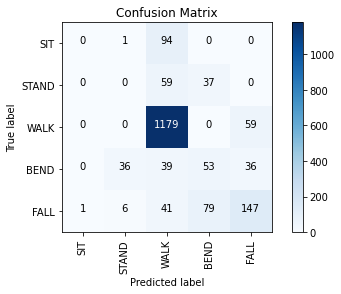

In [ ]:

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt


pred = LSTM_model.predict(X_test)
n_classes = 5 

LABELS = [ 
    "SIT",
    "STAND",
    "WALK",
    "BEND",
    "FALL"
    ] 

# LABELS = [ "Normal","FALL"]
precision, recall, f_score, support = metrics.precision_recall_fscore_support(Y_test.argmax(1), pred.argmax(1),average="weighted")

print("precision",100 * precision)
print("recall", 100 * recall)
print("f_score",100 * f_score)

print("number of occurrences of each class in test data", support)
print("confusion matrix")
confusion_matrix_basic = metrics.confusion_matrix(Y_test.argmax(1), pred.argmax(1))
print(confusion_matrix_basic)

cm = confusion_matrix(  Y_test.argmax(1), pred.argmax(1) ) 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j], fmt),
  horizontalalignment="center", 
  color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


FOR PLOTTING MODEL:

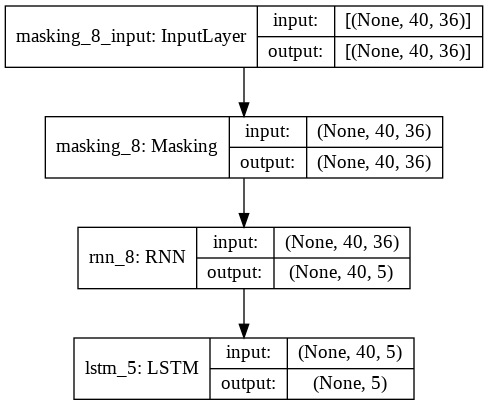

In [ ]:
keras.utils.plot_model(LSTM_model, 'multi_input_and_output_model.png', show_shapes=True)

# SAVE MODEL AND ITS WEIGHTS

In [ ]:
path = "/content/drive/My Drive/lstm models/feb10/models/A/"
name = "LSTM_A"
LSTM_model.save_weights(path)
LSTM_model.save(path + name + '.h5' )

#JUST FOR UNDERSTANDING UNITS PARAMETER IN LSTM:

In [ ]:
# Example of one output for each input time step
from keras.models import Sequential
from keras.layers import LSTM
from numpy import array
# define model where LSTM is also output layer
model = Sequential()
model.add(LSTM(3, return_sequences=True, input_shape=(3,1)))
model.compile(optimizer='adam', loss='mse')
# input time steps
data = array([0.1, 0.2, 0.3]).reshape((1,3,1))
#print(data[0][0])
# make and show prediction
print(model.predict(data))

# NOT PART OF TRAIN AND TEST PIPELINE:

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
seq_len = 12; emb_dim = 30; cells = 10
visible = Input(shape=(seq_len,emb_dim))
lstm1 = LSTM(cells,return_sequences = True)(visible)
lstm2 = LSTM(cells//2,return_sequences = False)(lstm1)
output = Dense(10, activation='sigmoid')(lstm2)
model = Model(inputs=visible, outputs=output)
model.summary()
print(model.layers[1].name)
for param in model.layers[1].trainable_variables:
    print(param.shape,param.name)

In [ ]:
import numpy as np

samples, timesteps, features = 1, 10, 8
inputs = np.random.random([samples, timesteps, features]).astype(np.float32)
inputs[:, 3, :] = 0.
inputs[:, 5, :] = 0.




model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Masking(mask_value=0.,
                                  input_shape=(timesteps, features)))

model.add(tf.keras.layers.LSTM(10))

output = model(inputs)

print(output)


# The time step 3 and 5 will be skipped from LSTM calculation.






tf.Tensor(
[[-0.05043752  0.33777654 -0.18593147  0.06093251 -0.0719891   0.10172012
  -0.11402737 -0.3126431  -0.04977654  0.14949141]], shape=(1, 10), dtype=float32)
